In [1]:
import wrangle
from explore import *
from modeling import *

import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.cluster import KMeans
from sklearn import linear_model as lm
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

In [2]:
def hist_plot(df):
    '''
    Plots Histograms for columns in the input Data Frame, 
    '''
    plt.figure(figsize=(26, 6))

    cols = [col for col in df.columns if col not in ['parcelid', 'yearbuilt', "lot_dollar_sqft_bin", 'lotsizesquarefeet', 'fips', 'age', 'age_bin', 'date', 'LA', 'Orange', 'Ventura', 'cola', 'longitude', 'latitude', 'regionalidcity', 'regionalidzip']]

    for i, col in enumerate(cols):

        # i starts at 0, but plot nos should start at 1 <-- Good to note
        plot_number = i + 1 
        plt.subplot(1, len(cols), plot_number)
        plt.title(col)
        df[col].hist(bins=5)
        # We're looking for shape not actual details, so these two are set to 'off'
        plt.grid(False)
        plt.ticklabel_format(useOffset=False)
        # mitigate overlap: This is handy. Thank you.
        plt.tight_layout()

    plt.show()

In [3]:
def box_plot(df, cols):
    ''' 
    Takes in a Data Frame, and list of columns
    Plots Boxplots of input columns.
    '''
    
    plt.figure(figsize=(16, 3))

    for i, col in enumerate(cols):
        plot_number = i + 1 
        plt.subplot(1, len(cols), plot_number)
        plt.title(col)
        sns.boxplot(data=df[[col]])
        plt.grid(False)
        plt.tight_layout()

    plt.show()

In [4]:
def plot_variable_pairs(df, num_pair):
    '''
    Takes in DF (Train Please,) and numerical column pair 
    Returns the plotted out variable pairs heatmap and numerical pairplot.
    '''
    df_corr = df.corr()
    plt.figure(figsize=(12,8))
    sns.heatmap(df_corr, cmap='Purples', annot = True, mask= np.triu(df_corr), linewidth=.5)
    plt.title("Correlations between variables")
    plt.show()
    
    sns.pairplot(df[num_pair].sample(1_000), corner=True, kind='reg', plot_kws={'line_kws':{'color':'red'}})
    plt.show()

In [5]:
def plot_categorical_and_continuous_vars(df, cat, target = 'logerror'):
    '''
    Takes a Data Frame,
    plots a continuous varible [default target value of logerror](please enter an int/float column) as y
    sorted by categorical variable as x.
    Returns swarm plot, violin plot, and cat plot for each.
    '''

    fig, ax = plt.subplots(figsize=(16, 6))
    for col in cat:
        
        sns.swarmplot(data=df.sample(800), x=col, y=target, s=3)
        # fixing number of tick marks
        plt.locator_params(axis='x', nbins=10)
        plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
        plt.show()

        sns.violinplot(data=df.sample(1_000), x=col, y=target, s=4)
         # fixing number of tick marks
        plt.locator_params(axis='x', nbins=10)
        plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
        plt.show()
        
        sns.catplot(data=df.sample(500), x=col, y=target, s=4)
         # fixing number of tick marks
        plt.locator_params(axis='x', nbins=10)
        plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
        plt.show()

In [6]:
def scale(df, columns_for_scaling = ['bathrooms', 'bedrooms', 'area', 'age', 'acres', 'bath_bed_ratio', 'sqft_bin', 'structure_dollar_per_sqft'], scaler = MinMaxScaler()):
    '''
    Takes in df, columns to be scaled (default: bedrooms, bathrooms, tax_value), 
    and scaler (default: MinMaxScaler(); others can be used ie: StandardScaler(), RobustScaler(), QuantileTransformer())
    returns a copy of the df, scaled.
    '''
    scaled_df = df.copy()
    scaled_df[columns_for_scaling] = scaler.fit_transform(df[columns_for_scaling])
    return scaled_df

In [7]:
def elbow(train_scaled, variables, start = 2, finish = 15):
    X = train_scaled[variables]
    pd.Series(
        {k: KMeans(k).fit(X).inertia_
        for k in range(start,finish)}).plot(marker='*')
    plt.ylabel('Inertia')
    plt.xlabel("k Number of clusters")
    plt.title("Change in Inertia as K Increases")
    plt.show()

In [8]:
def cluster(df_scaled, variables, n_clusters = 5):
    '''
    Takes Scaled Train Dataframe, variables to use to find clusters, and number of clusters desired [default: 5]
    Fits them with KMeans,
    Returns Cluster Predictions [Save as a column in your dataframe.]
    '''
    X = df_scaled[variables]
    kmeans = KMeans(n_clusters)
    kmeans.fit(X)
    return kmeans.predict(X)

------

In [9]:
df = wrangle.wrangle_zillow()

In [10]:
# Saving a clean copy so I can drop and change my working copy and always have a fresh one to add things back in with.
original = df.copy()

In [11]:
df.head()

,parcelid,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,...,taxrate,acres,acres_bin,sqft_bin,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio,cola
0,14297519,0.025595,3.5,4.0,3100.0,6059.0,33634931.0,-117869207.0,4506.0,53571.0,...,1.076313,0.103444,0.1,0.7,156.681613,0.5,119.300710,0.5,0.875000,0
1,17052889,0.055619,1.0,2.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,13091.0,...,1.222517,0.290335,0.3,0.3,60.068259,0.2,29.730371,0.3,0.500000,0
2,14186244,0.005383,2.0,3.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,21412.0,...,1.148823,0.193572,0.2,0.2,68.615447,0.2,56.865394,0.4,0.666667,0
3,12177905,-0.103410,3.0,4.0,2376.0,6037.0,34245180.0,-118240722.0,13038.0,396551.0,...,1.224661,0.299311,0.3,0.5,45.840909,0.1,2.778417,0.1,0.750000,0
4,12095076,-0.001011,3.0,4.0,2962.0,6037.0,34145202.0,-118179824.0,63000.0,47019.0,...,1.230599,1.446281,0.5,0.6,93.411209,0.3,7.882841,0.2,0.750000,0


In [12]:
df.describe()

,parcelid,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,regionidcity,...,taxrate,acres,acres_bin,sqft_bin,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio,cola
count,5.173600e+04,51736.000000,51736.000000,51736.000000,51736.000000,51736.000000,5.173600e+04,5.173600e+04,51736.000000,50760.000000,...,51736.000000,51736.000000,51736.000000,51736.000000,51678.000000,51678.000000,51736.000000,51735.000000,51736.000000,51736.000000
mean,1.296102e+07,0.017920,2.287150,3.301396,1903.958482,6049.173805,3.402159e+07,-1.181933e+08,9910.415900,33538.303054,...,1.325865,0.227512,0.167630,0.393386,90.226962,0.278637,48.410575,0.289759,0.696918,0.217605
std,2.279761e+06,0.173132,0.974628,0.914234,933.775224,21.044615,2.736498e+05,3.567360e+05,20980.396087,49254.586713,...,0.359271,0.481644,0.102886,0.186466,58.827734,0.146407,73.551646,0.128690,0.234700,0.412621
min,1.071186e+07,-4.655420,1.000000,1.000000,152.000000,6037.000000,3.334085e+07,-1.194753e+08,236.000000,3491.000000,...,0.009372,0.005418,0.000000,0.000000,0.039833,0.000000,0.013963,0.000000,0.200000,0.000000
25%,1.151209e+07,-0.024615,2.000000,3.000000,1267.000000,6037.000000,3.382637e+07,-1.183992e+08,5576.000000,12447.000000,...,1.163430,0.128007,0.100000,0.300000,54.791076,0.200000,9.471214,0.200000,0.500000,0.000000
50%,1.258499e+07,0.006852,2.000000,3.000000,1655.000000,6037.000000,3.402082e+07,-1.181517e+08,6827.000000,24812.000000,...,1.232578,0.156726,0.200000,0.400000,81.909234,0.300000,30.500757,0.300000,0.666667,0.000000
75%,1.413042e+07,0.040307,3.000000,4.000000,2296.000000,6059.000000,3.418679e+07,-1.179287e+08,8750.000000,40227.000000,...,1.367701,0.200872,0.200000,0.500000,113.057639,0.400000,59.895675,0.400000,0.800000,0.000000
max,1.629608e+08,3.394544,7.000000,7.000000,9848.000000,6111.000000,3.481877e+07,-1.175546e+08,862329.000000,396556.000000,...,9.805110,19.796350,0.700000,0.900000,1444.221106,0.900000,2954.227928,0.900000,3.000000,1.000000


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51736 entries, 0 to 52441
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      51736 non-null  int64  
 1   logerror                      51736 non-null  float64
 2   bathroomcnt                   51736 non-null  float64
 3   bedroomcnt                    51736 non-null  float64
 4   calculatedfinishedsquarefeet  51736 non-null  float64
 5   fips                          51736 non-null  float64
 6   latitude                      51736 non-null  float64
 7   longitude                     51736 non-null  float64
 8   lotsizesquarefeet             51736 non-null  float64
 9   regionidcity                  50760 non-null  float64
 10  regionidzip                   51736 non-null  float64
 11  yearbuilt                     51708 non-null  float64
 12  structuretaxvaluedollarcnt    51678 non-null  float64
 13  t

In [14]:
# There's a few nulls, but we'll lose less than 100 entries, so I don't mind dropping them for right now.
df = df.dropna()

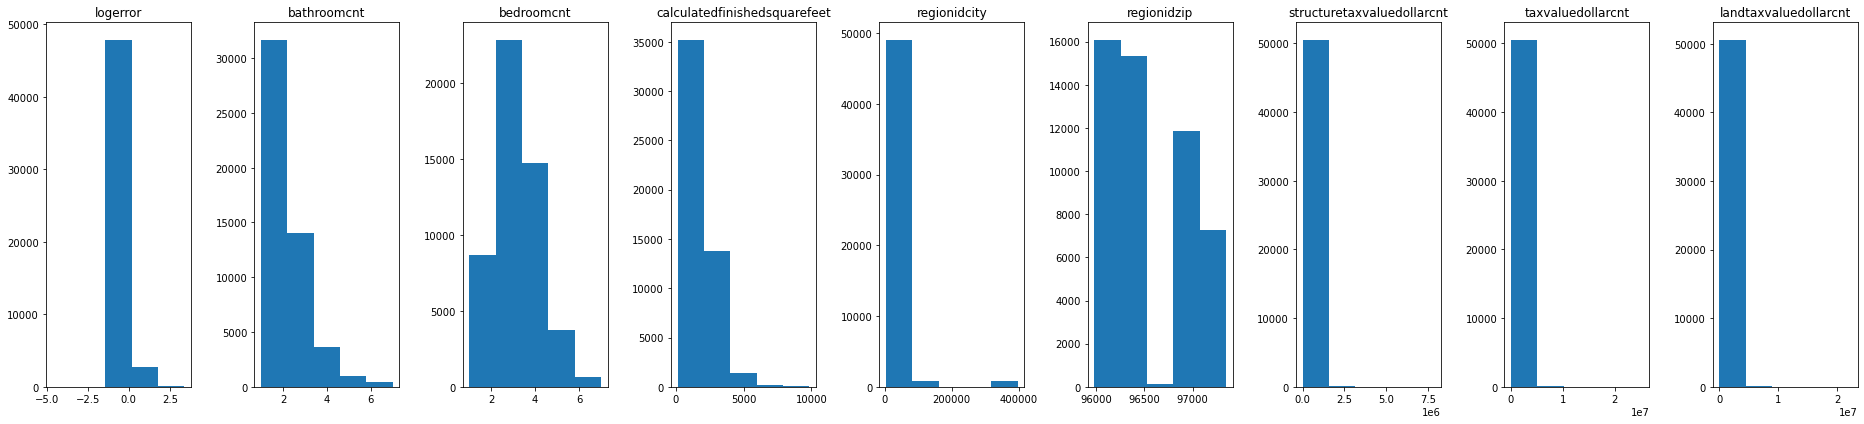

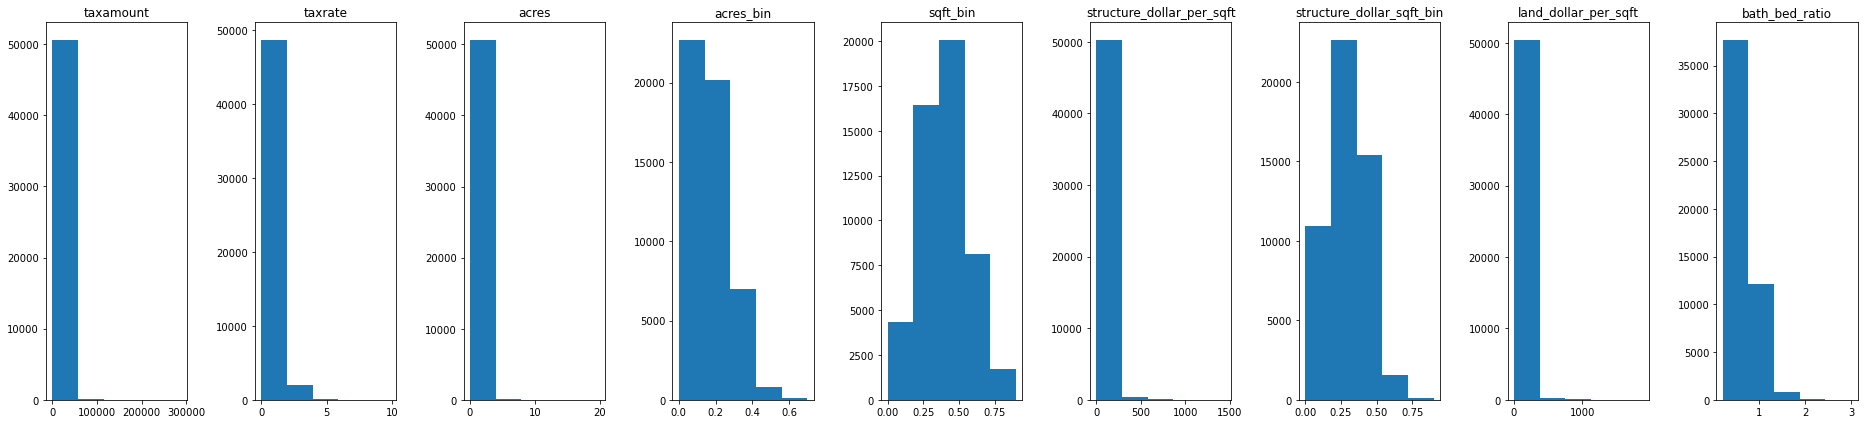

In [15]:
# Partitioning a copy of the data into two parts to make the histograms more visible.
df_plot = df.copy()
df_plot1 = df_plot.iloc[ : ,:15]
hist_plot(df_plot1)
plt.show()
df_plot2 = df_plot.iloc[ : ,15:]
hist_plot(df_plot2)
plt.show()

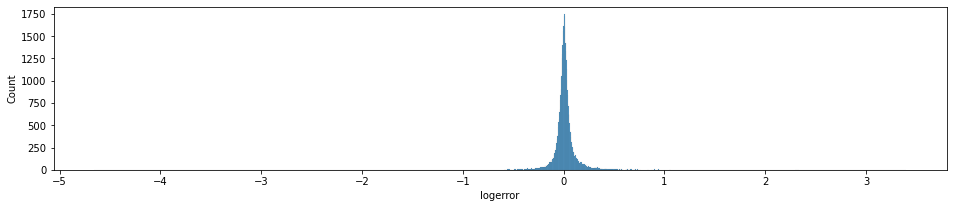

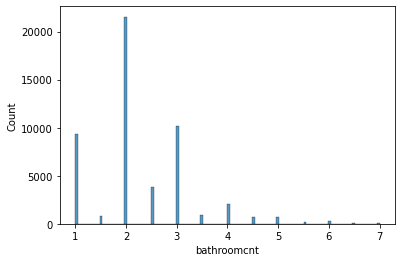

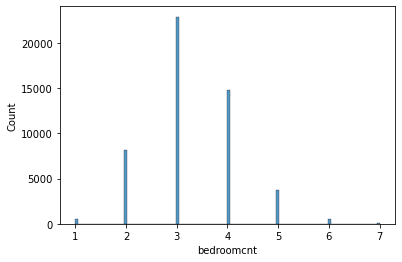

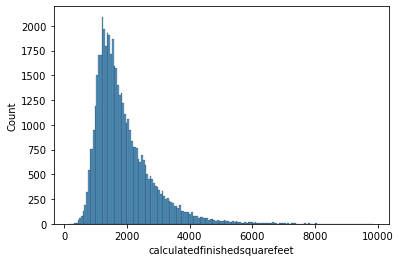

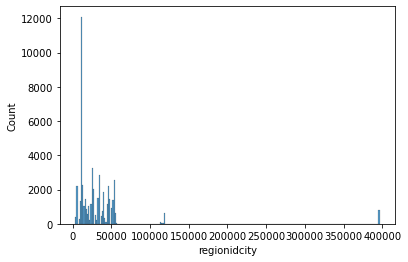

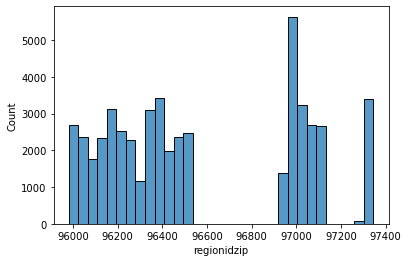

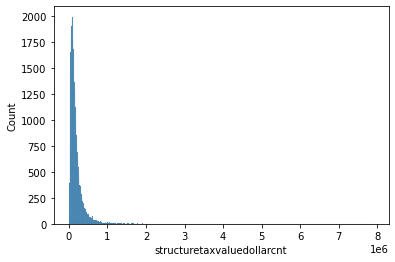

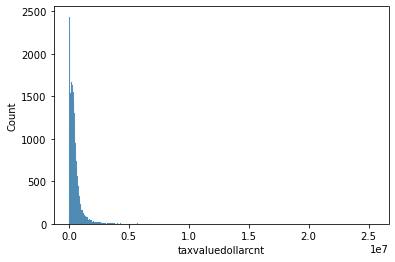

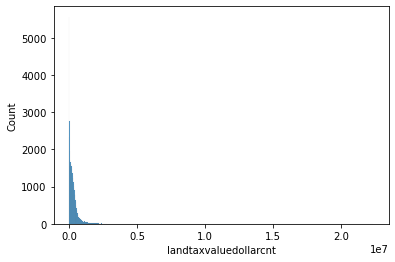

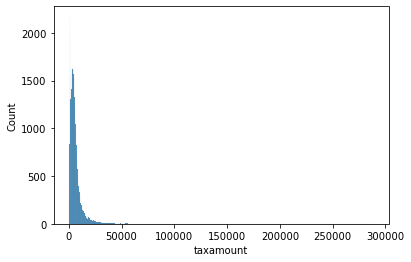

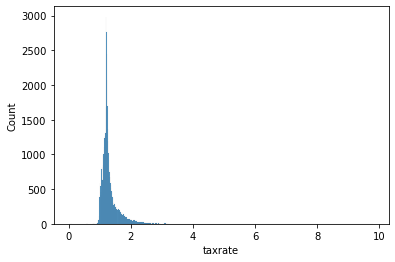

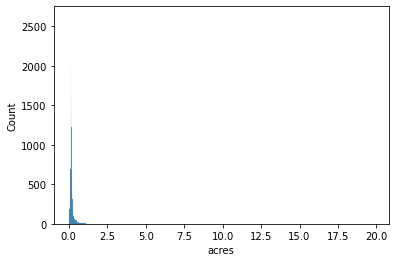

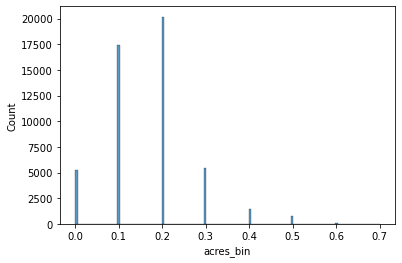

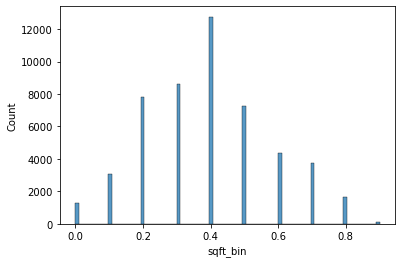

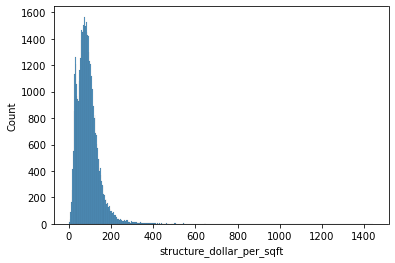

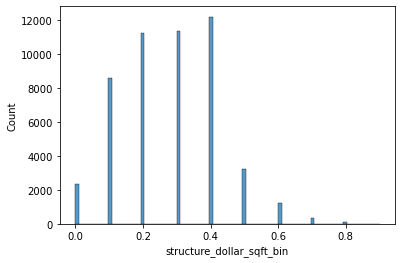

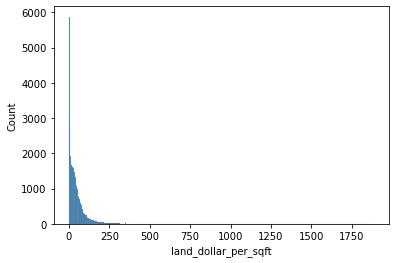

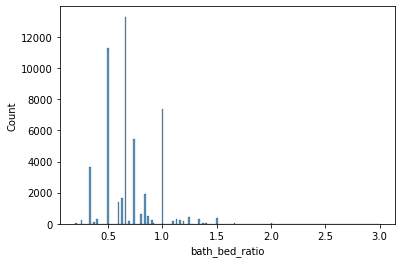

In [16]:
plt.figure(figsize=(16, 3))
cols = [col for col in df.columns if col not in ['parcelid', 
                                        'yearbuilt', 
                                        'lot_dollar_sqft_bin', 
                                        'lotsizesquarefeet', 
                                        'fips', 
                                        'age', 
                                        'age_bin', 
                                        'LA', 
                                        'Orange', 
                                        'Ventura', 
                                        'cola', 
                                        'longitude', 
                                        'latitude', 
                                        'regionalidcity', 
                                        'regionalidzip']]
for i, col in enumerate(cols):
    sns.histplot(data = df, x= col)
    plt.show()

In [17]:
# Lowering some of the features for an MVP
df = df.drop(columns=["cola", "lot_dollar_sqft_bin", "land_dollar_per_sqft", "yearbuilt", 'regionidcity','regionidzip','structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'longitude', 'latitude'])

In [18]:
df.head()

,parcelid,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,lotsizesquarefeet,taxvaluedollarcnt,taxamount,LA,...,Ventura,age,age_bin,taxrate,acres,acres_bin,sqft_bin,structure_dollar_per_sqft,structure_dollar_sqft_bin,bath_bed_ratio
0,14297519,0.025595,3.5,4.0,3100.0,6059.0,4506.0,1023282.0,11013.72,0,...,0,19.0,0.133,1.076313,0.103444,0.1,0.7,156.681613,0.5,0.875000
1,17052889,0.055619,1.0,2.0,1465.0,6111.0,12647.0,464000.0,5672.48,0,...,1,50.0,0.333,1.222517,0.290335,0.3,0.3,60.068259,0.2,0.500000
2,14186244,0.005383,2.0,3.0,1243.0,6059.0,8432.0,564778.0,6488.30,0,...,0,55.0,0.400,1.148823,0.193572,0.2,0.2,68.615447,0.2,0.666667
3,12177905,-0.103410,3.0,4.0,2376.0,6037.0,13038.0,145143.0,1777.51,1,...,0,47.0,0.333,1.224661,0.299311,0.3,0.5,45.840909,0.1,0.750000
4,12095076,-0.001011,3.0,4.0,2962.0,6037.0,63000.0,773303.0,9516.26,1,...,0,67.0,0.466,1.230599,1.446281,0.5,0.6,93.411209,0.3,0.750000


In [19]:
df.groupby('fips').agg(['min','max', 'median', 'std', 'mean']).T

fips                                       6037.0        6059.0        6111.0
parcelid                     min     1.071186e+07  1.383453e+07  1.705102e+07
                             max     1.310223e+07  1.476274e+07  1.629608e+08
                             median  1.189374e+07  1.419787e+07  1.719464e+07
                             std     7.251356e+05  1.966417e+05  4.955942e+06
                             mean    1.187648e+07  1.419231e+07  1.735264e+07
logerror                     min    -4.655420e+00 -2.406257e+00 -2.311473e+00
                             max     3.394544e+00  2.933328e+00  2.311174e+00
                             median  5.951109e-03  8.373732e-03  6.221870e-03
                             std     1.654864e-01  1.970848e-01  1.550980e-01
                             mean    1.468053e-02  2.661410e-02  1.538391e-02
bathroomcnt                  min     1.000000e+00  1.000000e+00  1.000000e+00
                             max     7.000000e+00  7.000000e+00  7.000000e+00
                             median  2.000000e+00  2.500000e+00  2.000000e+00
                             std     9.908846e-01  8.934214e-01  8.755028e-01
                             mean    2.157253e+00  2.508804e+00  2.471895e+00
bedroomcnt                   min     1.000000e+00  1.000000e+00  1.000000e+00
                             max     7.000000e+00  7.000000e+00  7.000000e+00
                             median  3.000000e+00  3.000000e+00  4.000000e+00
                             std     9.113110e-01  8.847252e-01  8.367551e-01
                             mean    3.182355e+00  3.480529e+00  3.578533e+00
calculatedfinishedsquarefeet min     1.520000e+02  3.800000e+02  3.000000e+02
                             max     9.848000e+03  9.586000e+03  9.660000e+03
                             median  1.544000e+03  1.879000e+03  1.858000e+03
                             std     8.849566e+02  9.698637e+02  9.629455e+02
                             mean    1.777370e+03  2.113710e+03  2.099263e+03
lotsizesquarefeet            min     9.090000e+02  4.800000e+02  2.360000e+02
                             max     8.623290e+05  2.962080e+05  4.822090e+05
                             median  6.892000e+03  6.375000e+03  7.425000e+03
                             std     2.321756e+04  7.136600e+03  2.244568e+04
                             mean    1.042415e+04  7.371969e+03  1.224067e+04
taxvaluedollarcnt            min     3.254000e+03  1.381700e+04  1.543300e+04
                             max     2.538125e+07  1.131768e+07  1.319825e+07
                             median  3.169380e+05  4.715690e+05  4.416330e+05
                             std     6.827924e+05  5.864472e+05  4.292714e+05
                             mean    4.777003e+05  5.954291e+05  5.099393e+05
taxamount                    min     1.208400e+02  3.435200e+02  4.918000e+01
                             max     2.885246e+05  1.159233e+05  1.433367e+05
                             median  4.204360e+03  5.395540e+03  5.047440e+03
                             std     7.966254e+03  6.514237e+03  4.752330e+03
                             mean    6.009669e+03  6.857541e+03  5.849592e+03
LA                           min     1.000000e+00  0.000000e+00  0.000000e+00
                             max     1.000000e+00  0.000000e+00  0.000000e+00
                             median  1.000000e+00  0.000000e+00  0.000000e+00
                             std     0.000000e+00  0.000000e+00  0.000000e+00
                             mean    1.000000e+00  0.000000e+00  0.000000e+00
Orange                       min     0.000000e+00  1.000000e+00  0.000000e+00
                             max     0.000000e+00  1.000000e+00  0.000000e+00
                             median  0.000000e+00  1.000000e+00  0.000000e+00
                             std     0.000000e+00  0.000000e+00  0.000000e+00
                             mean    0.000000e+00  1.000000e+00  0.000000e+00
Ventura               

In [20]:
df.logerror.mean()

0.01796358713470303

In [21]:
df.logerror.groupby(df.fips).agg(['mean']).T

fips,6037.0,6059.0,6111.0
mean,0.014681,0.026614,0.015384


In [22]:
df.logerror.groupby(df.bedroomcnt).agg(['mean']).T

bedroomcnt,1.0,2.0,3.0,4.0,5.0,6.0,7.0
mean,0.02152,0.011671,0.014609,0.021564,0.034449,0.033401,0.04456


In [23]:
df = df.rename(columns={'bathroomcnt' : 'bathrooms', 'bedroomcnt' : 'bedrooms', 'calculatedfinishedsquarefeet': 'area', 'taxvaluedollarcnt': 'tax_value', 'taxamount': 'tax_amount', 'taxrate':'tax_rate'})

In [24]:
df.columns

Index(['parcelid', 'logerror', 'bathrooms', 'bedrooms', 'area', 'fips',
       'lotsizesquarefeet', 'tax_value', 'tax_amount', 'LA', 'Orange',
       'Ventura', 'age', 'age_bin', 'tax_rate', 'acres', 'acres_bin',
       'sqft_bin', 'structure_dollar_per_sqft', 'structure_dollar_sqft_bin',
       'bath_bed_ratio'],
      dtype='object')

In [25]:
cols = ['bathrooms', 'bedrooms', 'sqft_bin', 'fips','acres_bin', 'structure_dollar_sqft_bin', 'bath_bed_ratio']
for col in cols:
    print(f'======{col}======')
    print(df.logerror.groupby(df[col]).agg(['mean']).T)
    print("  ")

======bathrooms======
bathrooms       1.0      1.5       2.0     2.5       3.0      3.5       4.0  \
mean       0.014425  0.01979  0.014511  0.0199  0.018711  0.03106  0.033202   

bathrooms       4.5       5.0       5.5       6.0       6.5       7.0  
mean       0.055679  0.030819  0.050243  0.023215  0.065857  0.051444  
  
======bedrooms======
bedrooms      1.0       2.0       3.0       4.0       5.0       6.0      7.0
mean      0.02152  0.011671  0.014609  0.021564  0.034449  0.033401  0.04456
  
======sqft_bin======
sqft_bin       0.0       0.1       0.2      0.3      0.4       0.5       0.6  \
mean      0.024895  0.016947  0.013687  0.01353  0.01435  0.016841  0.023421   

sqft_bin       0.7       0.8       0.9  
mean      0.028765  0.047796  0.091999  
  
======fips======
fips    6037.0    6059.0    6111.0
mean  0.014681  0.026614  0.015384
  
======acres_bin======
acres_bin      0.0       0.1       0.2       0.3       0.4       0.5  \
mean       0.01831  0.016143  0.016465  0.0

Looking at the various average log error by different categories, there are a few areas where it really stands out.

> Looking at the FIPS groupby.agg log error mean is 0.026451 for 6059 vs. 0.014698 and 0.015169 for 6037 and 6111 respectively.

> Looking at bedrooms, the mean seems fairly standard until you get to 5+

> sqft_bin is fairly average, a slight rise, but at 0.8 it rises to 0.046944 then almost doubles at 0.9 to 0.086096

> structure_dollar_sqft_bin log error mean is fairly standard until 0.7 then it suddenly drops to significantly close to no error at 0.001062, then continues to plummet at 0.8 to -0.058, then quickly rise to 0.071403

> bath_bed_ratio also has a few dips to below 0, as well as one mean at -0.000477 (the closest to 0 I’ve seen so far.)

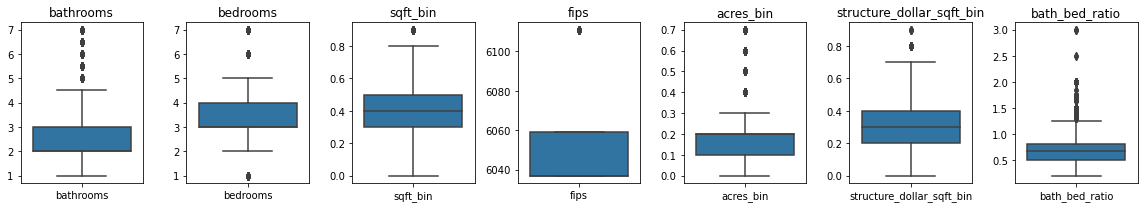

In [26]:
box_plot(df, cols)

-----

In [27]:
train, X_train, X_validate, X_test, y_train, y_validate, y_test = wrangle.split(df, 'logerror')
train.shape, X_train.shape, y_train.shape, X_validate.shape, y_validate.shape, X_test.shape, y_test.shape

((28378, 21),
 (28378, 20),
 (28378, 1),
 (12163, 20),
 (12163, 1),
 (10136, 20),
 (10136, 1))

In [28]:
train.columns

Index(['parcelid', 'logerror', 'bathrooms', 'bedrooms', 'area', 'fips',
       'lotsizesquarefeet', 'tax_value', 'tax_amount', 'LA', 'Orange',
       'Ventura', 'age', 'age_bin', 'tax_rate', 'acres', 'acres_bin',
       'sqft_bin', 'structure_dollar_per_sqft', 'structure_dollar_sqft_bin',
       'bath_bed_ratio'],
      dtype='object')

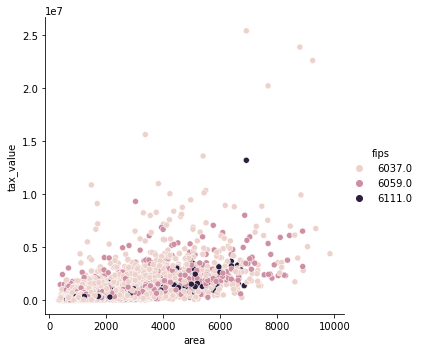

In [29]:
sns.relplot(data = train, x = "area", y= "tax_value", hue = "fips")
plt.show()

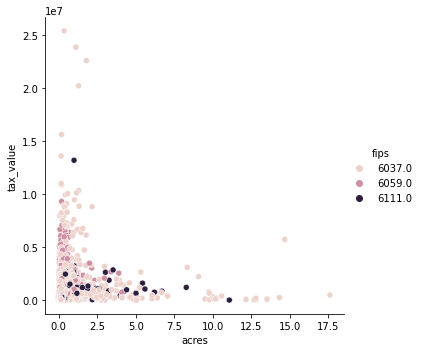

In [30]:
sns.relplot(data = train, x = "acres", y= "tax_value", hue = "fips")
plt.show()

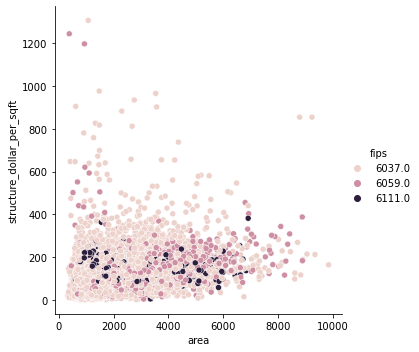

In [31]:
sns.relplot(data = train, x = "area", y= "structure_dollar_per_sqft", hue = "fips")
plt.show()

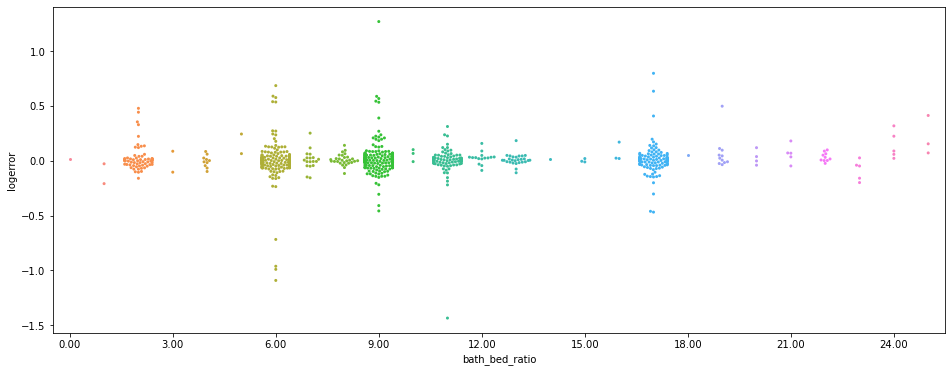

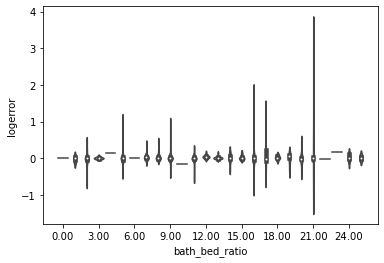

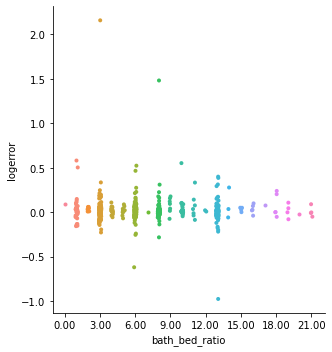

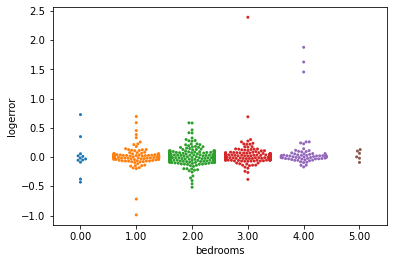

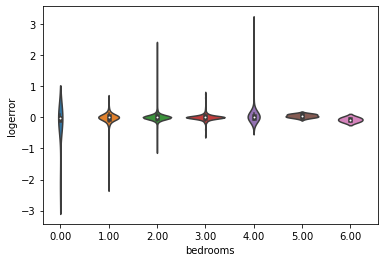

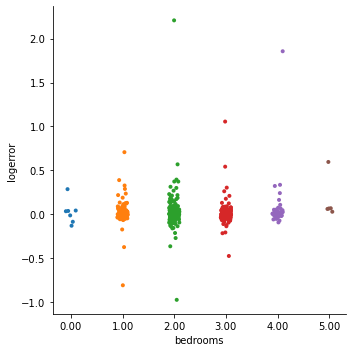

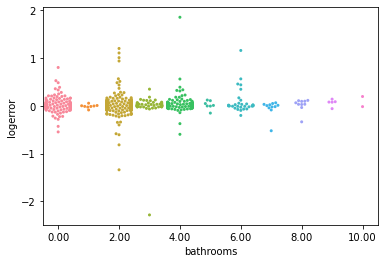

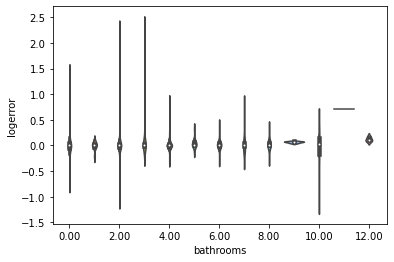

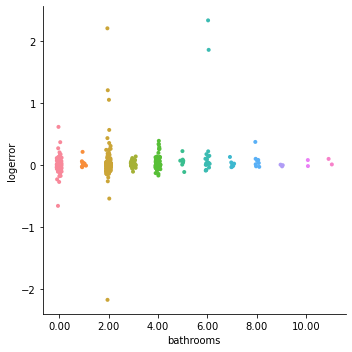

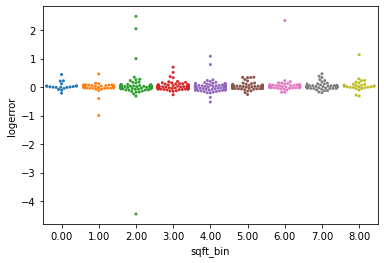

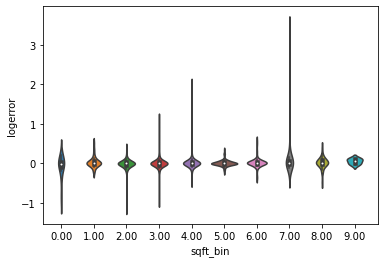

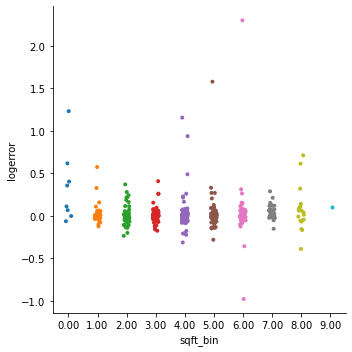

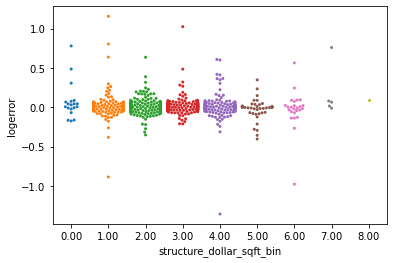

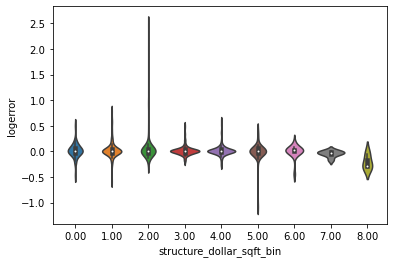

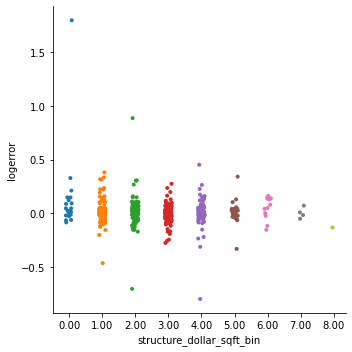

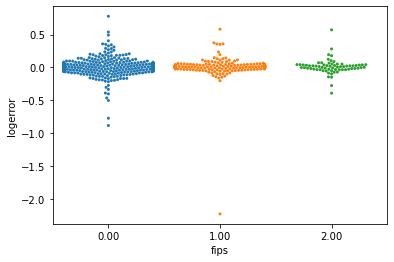

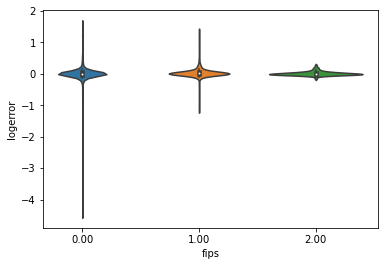

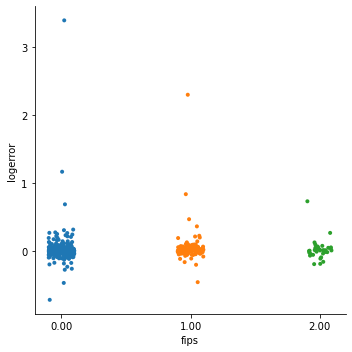

In [32]:
plot_categorical_and_continuous_vars(train, ['bath_bed_ratio', 'bedrooms', 'bathrooms', 'sqft_bin','structure_dollar_sqft_bin', 'fips'])

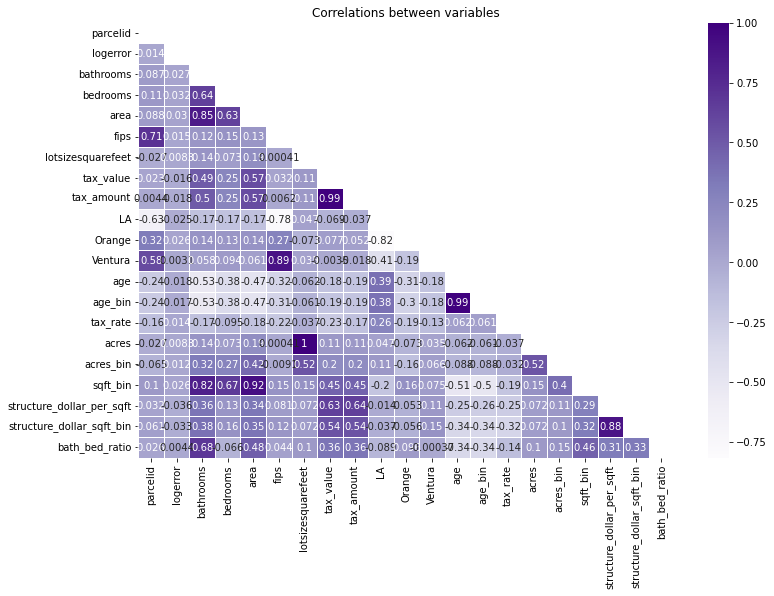

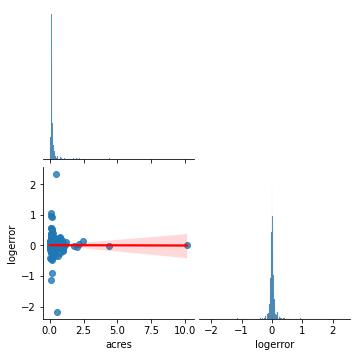

In [33]:
plot_variable_pairs(train,['acres', 'logerror'])

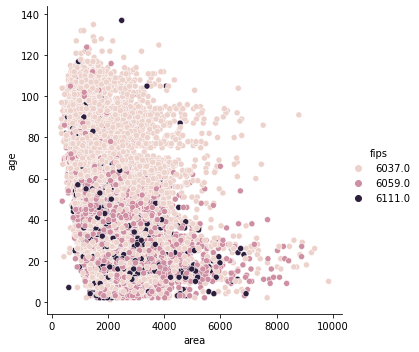

In [34]:
sns.relplot(data = train, x = "area", y= "age", hue = "fips")
plt.show()

----

I can't really say I see any clusters, perhaps for age just for the LA fips?

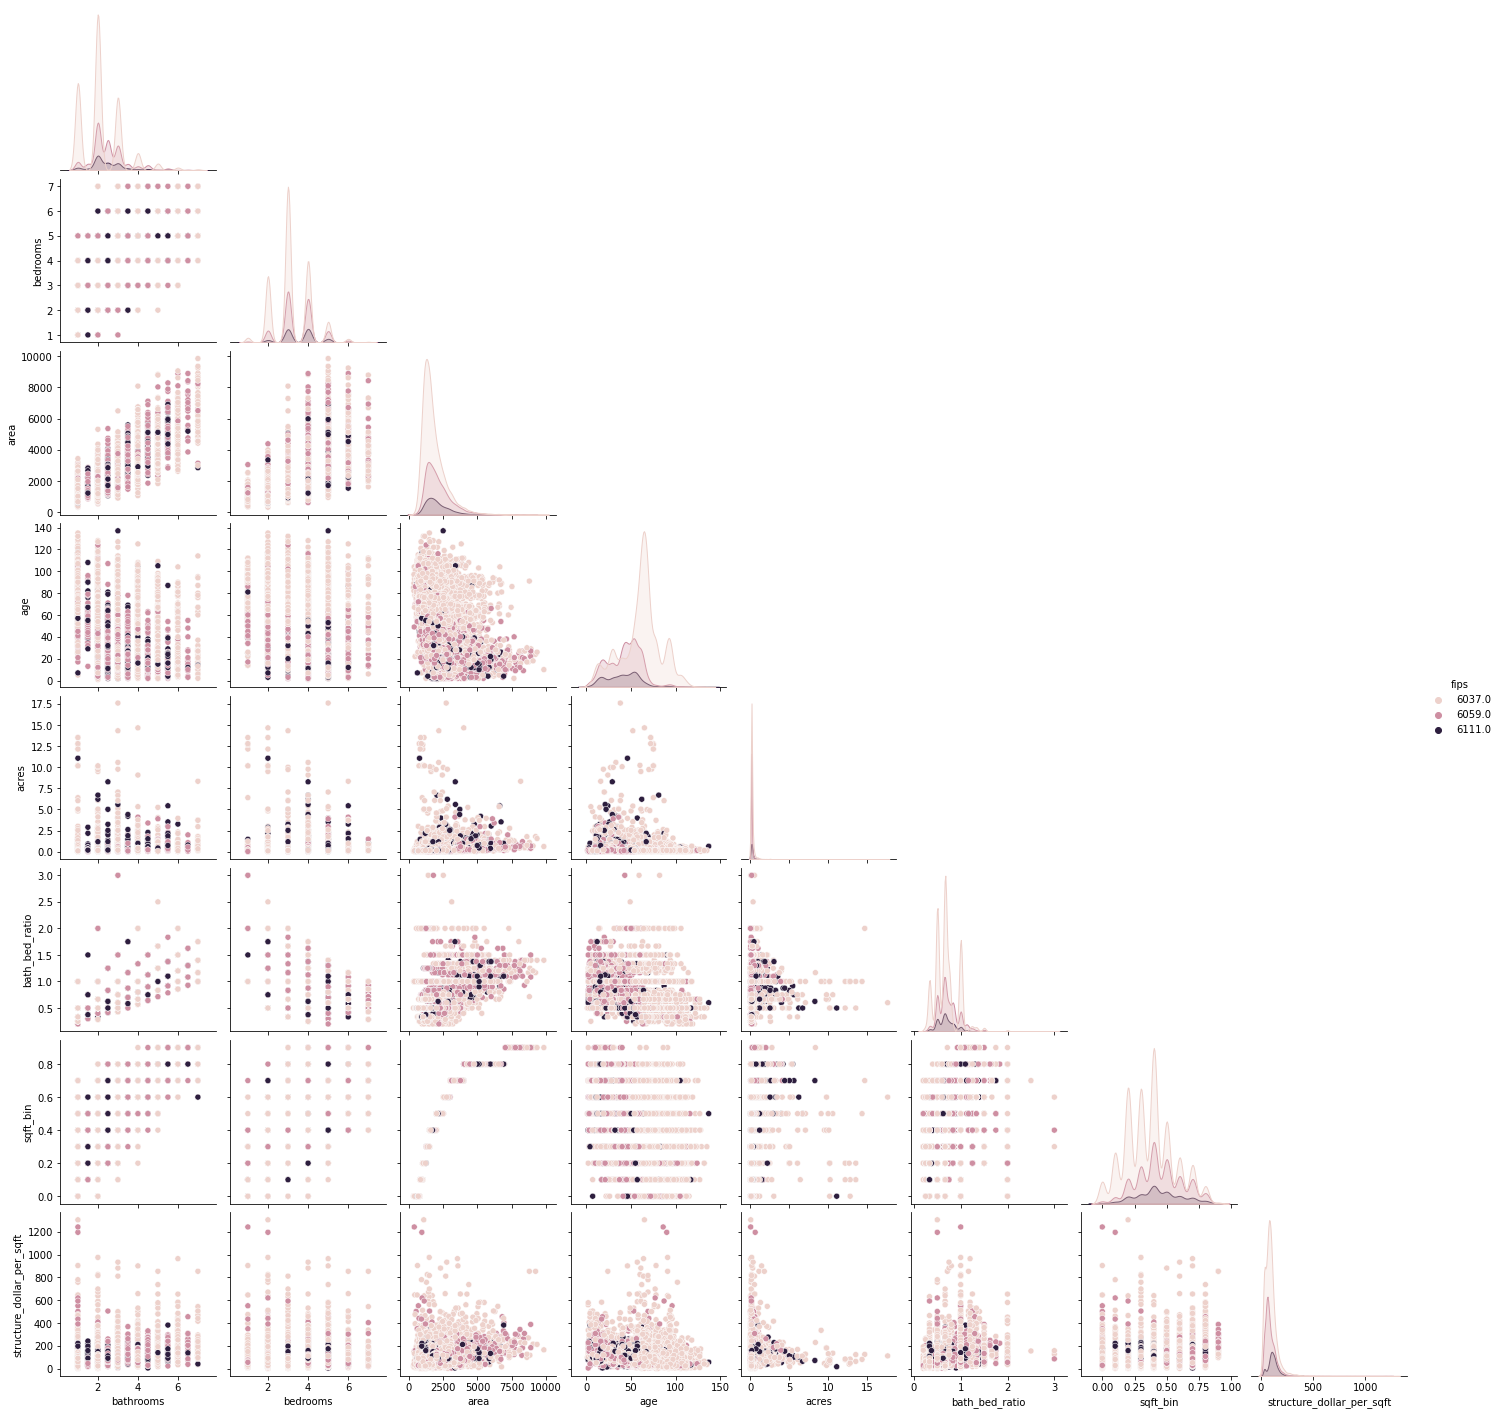

In [35]:
plt_df = X_train[['bathrooms', 'bedrooms', 'area', 'age',
                    'acres', 'bath_bed_ratio', 'sqft_bin', 'structure_dollar_per_sqft', 'fips']]

sns.pairplot(data=plt_df, hue='fips', corner = True)
plt.show()

------

In [36]:
# Let's scale.
df_scaled = scale(df)
df_scaled.head()

,parcelid,logerror,bathrooms,bedrooms,area,fips,lotsizesquarefeet,tax_value,tax_amount,LA,...,Ventura,age,age_bin,tax_rate,acres,acres_bin,sqft_bin,structure_dollar_per_sqft,structure_dollar_sqft_bin,bath_bed_ratio
0,14297519,0.025595,0.416667,0.500000,0.304043,6059.0,4506.0,1023282.0,11013.72,0,...,0,0.130435,0.133,1.076313,0.004953,0.1,0.777778,0.108464,0.5,0.241071
1,17052889,0.055619,0.000000,0.166667,0.135417,6111.0,12647.0,464000.0,5672.48,0,...,1,0.355072,0.333,1.222517,0.014396,0.3,0.333333,0.041566,0.2,0.107143
2,14186244,0.005383,0.166667,0.333333,0.112521,6059.0,8432.0,564778.0,6488.30,0,...,0,0.391304,0.400,1.148823,0.009507,0.2,0.222222,0.047484,0.2,0.166667
3,12177905,-0.103410,0.333333,0.500000,0.229373,6037.0,13038.0,145143.0,1777.51,1,...,0,0.333333,0.333,1.224661,0.014850,0.3,0.555556,0.031714,0.1,0.196429
4,12095076,-0.001011,0.333333,0.500000,0.289810,6037.0,63000.0,773303.0,9516.26,1,...,0,0.478261,0.466,1.230599,0.072804,0.5,0.666667,0.064654,0.3,0.196429


In [37]:
train_scaled, X_train_s, X_validate_s, X_test_s, y_train, y_validate, y_test = wrangle.split(df_scaled, 'logerror')

In [38]:
elbow(train_scaled, ["structure_dollar_per_sqft", "area"])

In [39]:
train['area_dollar_clusters'] = cluster(train_scaled, ['structure_dollar_per_sqft', 'area'])
X_validate_s['area_dollar_clusters'] = cluster(X_validate_s, ['structure_dollar_per_sqft', 'area'])
X_test_s['area_dollar_clusters'] = cluster(X_test_s, ['structure_dollar_per_sqft', 'area'])


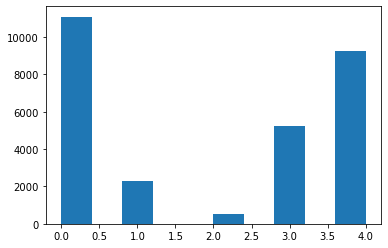

In [40]:
plt.hist(train.area_dollar_clusters)
plt.show()

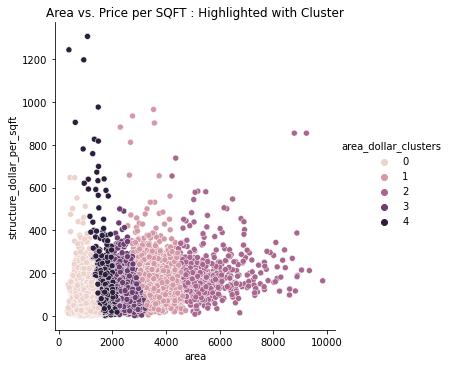

In [41]:
sns.relplot(data=train, 
            x="area",
            y="structure_dollar_per_sqft", 
            hue = "area_dollar_clusters").set(
                title="Area vs. Price per SQFT : Highlighted with Cluster")
plt.show()

In [42]:
elbow(train_scaled, ['bedrooms', 'bathrooms','area'])

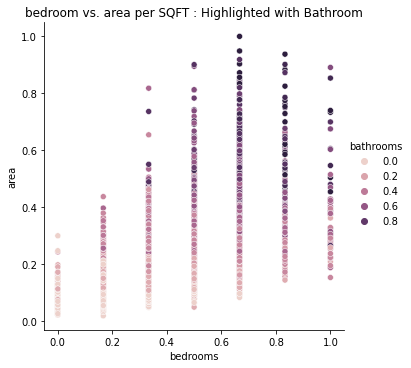

In [43]:
sns.relplot(data=train_scaled, 
            x="bedrooms",
            y="area", 
            hue = "bathrooms").set(
                title="bedroom vs. area per SQFT : Highlighted with Bathroom")
plt.show()

In [44]:
# -------

In [45]:
train['area_bedbath_clusters'] = cluster(train_scaled, ['bedrooms','bathrooms', 'area'], n_clusters=4)
X_validate_s['area_bedbath_clusters'] = cluster(X_validate_s, ['bedrooms','bathrooms', 'area'], n_clusters=4)
X_test_s['area_bedbath_clusters'] = cluster(X_test_s, ['bedrooms','bathrooms', 'area'], n_clusters=4)

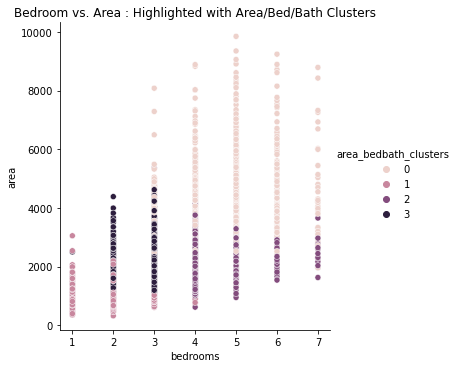

In [46]:
sns.relplot(data=train, 
            x="bedrooms",
            y="area", 
            hue = "area_bedbath_clusters").set(
                title="Bedroom vs. Area : Highlighted with Area/Bed/Bath Clusters")
plt.show()

> Hmm, interesting cluster choice. Let me see if changing the bottom to bathroom and such will shine some light on it.

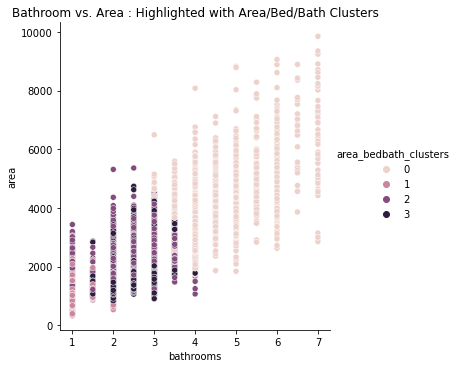

In [47]:
sns.relplot(data=train, 
            x="bathrooms",
            y="area", 
            hue = "area_bedbath_clusters").set(
                title="Bathroom vs. Area : Highlighted with Area/Bed/Bath Clusters")
plt.show()

> So far it looks like the lower values are more based on Bedroom vs. Area (which would make sense, from my project it showed that lower end of bedroom had a greater affect than lower end of bathrooms when it came to area and tax_value.) and the higher values are based on Bathroom vs. Area.

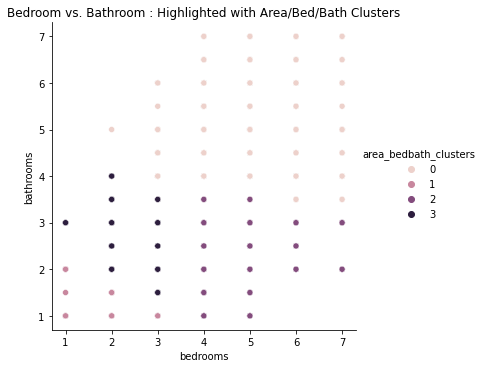

In [48]:
sns.relplot(data=train, 
            x="bedrooms",
            y="bathrooms", 
            hue = "area_bedbath_clusters").set(
                title="Bedroom vs. Bathroom : Highlighted with Area/Bed/Bath Clusters")
plt.show()

> Oh, nice, it looks nicely clustered on this one, and judging from the others vs. area also has a lot of that taken into account.

In [49]:
#   ['bathrooms', 'bedrooms', 'area', 'age', 'acres', 'bath_bed_ratio', 'sqft_bin', 'structure_dollar_per_sqft', 'fips']

In [50]:
elbow(train_scaled, ['tax_value', 'bathrooms','acres'])

In [51]:
train['acre_bath_value'] = cluster(train_scaled, ['tax_value','bathrooms', 'acres'], n_clusters=6)
X_validate_s['acre_bath_value'] = cluster(X_validate_s, ['tax_value','bathrooms', 'acres'], n_clusters=6)
X_test_s['acre_bath_value'] = cluster(X_test_s, ['tax_value','bathrooms', 'acres'], n_clusters=6)

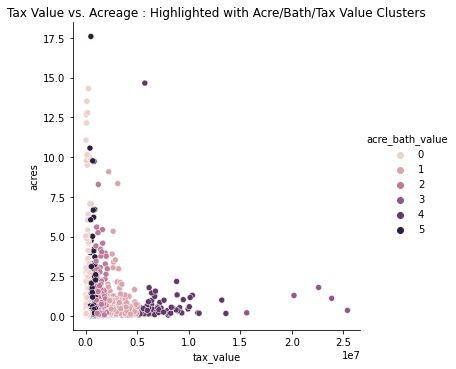

In [52]:
sns.relplot(data=train, 
            x="tax_value",
            y="acres", 
            hue = "acre_bath_value").set(
                title="Tax Value vs. Acreage : Highlighted with Acre/Bath/Tax Value Clusters")
plt.show()

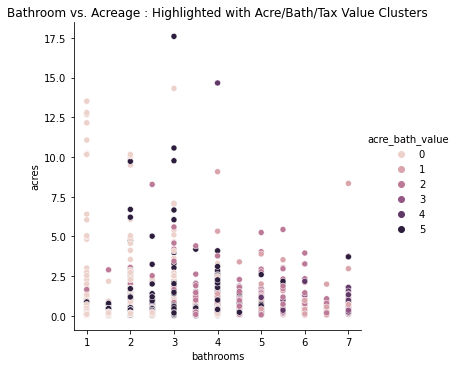

In [53]:
sns.relplot(data=train, 
            x="bathrooms",
            y="acres", 
            hue = "acre_bath_value").set(
                title="Bathroom vs. Acreage : Highlighted with Acre/Bath/Tax Value Clusters")
plt.show()

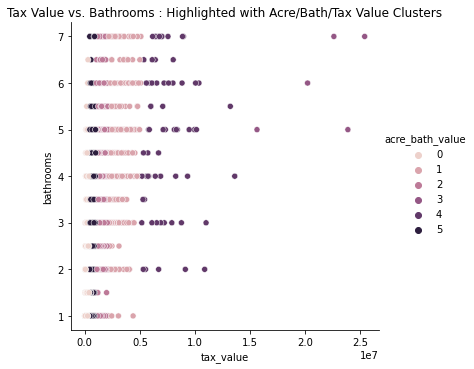

In [54]:
sns.relplot(data=train, 
            x="tax_value",
            y="bathrooms", 
            hue = "acre_bath_value").set(
                title="Tax Value vs. Bathrooms : Highlighted with Acre/Bath/Tax Value Clusters")
plt.show()

In [55]:
# Check size (area x acreage?) and zip?, maybe value?

In [56]:
elbow(train_scaled, ['acres', 'bedrooms' , 'bathrooms','structure_dollar_per_sqft'])

In [57]:
train['areas_valuepsqft'] = cluster(train_scaled, ['acres', 'bedrooms', 'bathrooms', 'structure_dollar_per_sqft'], n_clusters=6)
X_validate_s['areas_valuepsqft'] = cluster(X_validate_s, ['acres', 'bedrooms', 'bathrooms', 'structure_dollar_per_sqft'], n_clusters=6)
X_test_s['areas_valuepsqft'] = cluster(X_test_s, ['acres', 'bedrooms', 'bathrooms', 'structure_dollar_per_sqft'], n_clusters=6)

display(X_validate_s.head().T)

,13751,41780,51314,46241,33339
parcelid,1.446278e+07,1.081089e+07,1.198425e+07,1.175164e+07,1.426746e+07
bathrooms,3.333333e-01,1.666667e-01,3.333333e-01,1.666667e-01,1.666667e-01
bedrooms,6.666667e-01,3.333333e-01,3.333333e-01,5.000000e-01,3.333333e-01
area,2.669142e-01,1.934818e-01,3.017739e-01,2.985767e-01,1.897690e-01
fips,6.059000e+03,6.037000e+03,6.037000e+03,6.037000e+03,6.059000e+03
lotsizesquarefeet,6.433000e+03,5.858000e+03,1.049000e+04,7.485000e+03,2.199000e+03
tax_value,6.038560e+05,4.023440e+05,1.707368e+06,1.190863e+06,3.423080e+05
tax_amount,9.263200e+03,4.934870e+03,2.081365e+04,1.447075e+04,4.087960e+03
LA,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
Orange,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


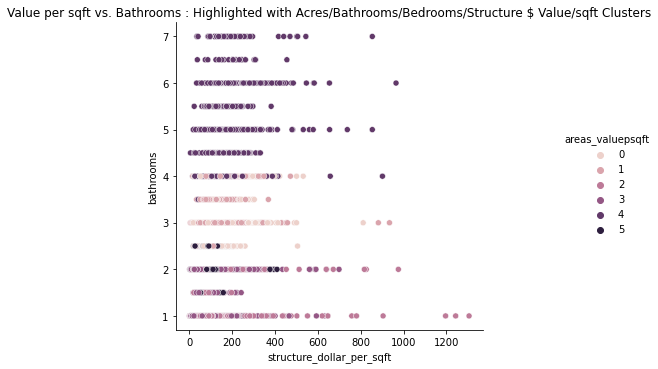

In [58]:
sns.relplot(data=train, 
            x="structure_dollar_per_sqft",
            y="bathrooms", 
            hue = "areas_valuepsqft").set(
                title="Value per sqft vs. Bathrooms : Highlighted with Acres/Bathrooms/Bedrooms/Structure $ Value/sqft Clusters")
plt.show()

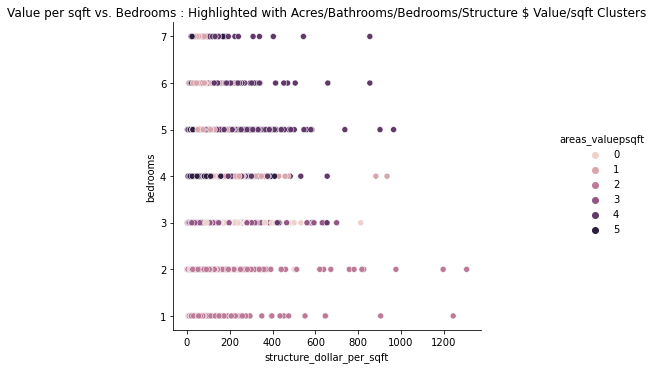

In [59]:
sns.relplot(data=train, 
            x="structure_dollar_per_sqft",
            y="bedrooms", 
            hue = "areas_valuepsqft").set(
                title="Value per sqft vs. Bedrooms : Highlighted with Acres/Bathrooms/Bedrooms/Structure $ Value/sqft Clusters")
plt.show()

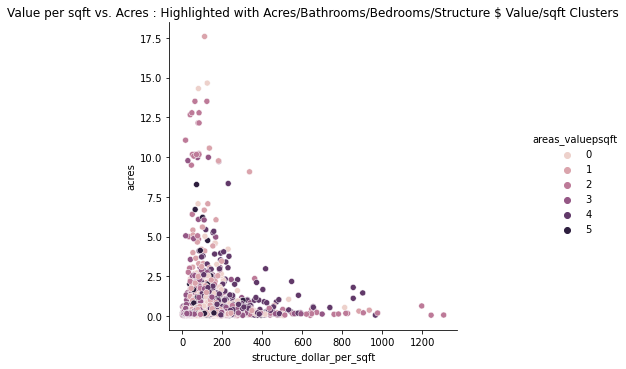

In [60]:
sns.relplot(data=train, 
            x="structure_dollar_per_sqft",
            y="acres", 
            hue = "areas_valuepsqft").set(
                title="Value per sqft vs. Acres : Highlighted with Acres/Bathrooms/Bedrooms/Structure $ Value/sqft Clusters")
plt.show()

------

> Stats, what sort of questions to ask.

Using our new clusters to explore relations with log error more.

In [61]:
train.columns

Index(['parcelid', 'logerror', 'bathrooms', 'bedrooms', 'area', 'fips',
       'lotsizesquarefeet', 'tax_value', 'tax_amount', 'LA', 'Orange',
       'Ventura', 'age', 'age_bin', 'tax_rate', 'acres', 'acres_bin',
       'sqft_bin', 'structure_dollar_per_sqft', 'structure_dollar_sqft_bin',
       'bath_bed_ratio', 'area_dollar_clusters', 'area_bedbath_clusters',
       'acre_bath_value', 'areas_valuepsqft'],
      dtype='object')

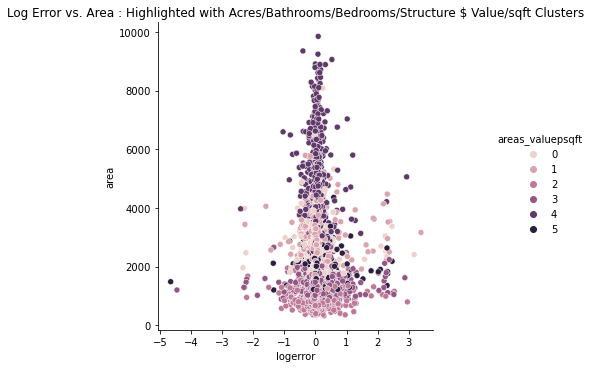

In [62]:
sns.relplot(data=train, 
            x="logerror",
            y="area", 
            hue = "areas_valuepsqft").set(
                title="Log Error vs. Area : Highlighted with Acres/Bathrooms/Bedrooms/Structure $ Value/sqft Clusters")
plt.show()

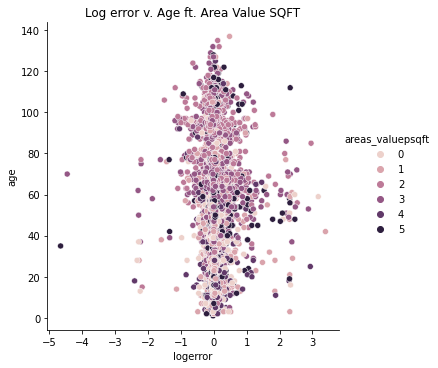

In [63]:
sns.relplot(data=train, 
            x="logerror",
            y="age", 
            hue = "areas_valuepsqft").set(
                title="Log error v. Age ft. Area Value SQFT")
plt.show()

> Oh, age has some weird pattern going with logerror. I want to explore this more later.

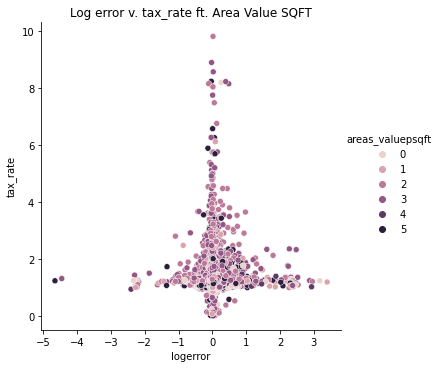

In [64]:
sns.relplot(data=train, 
            x="logerror",
            y="tax_rate", 
            hue = "areas_valuepsqft").set(
                title="Log error v. tax_rate ft. Area Value SQFT")
plt.show()

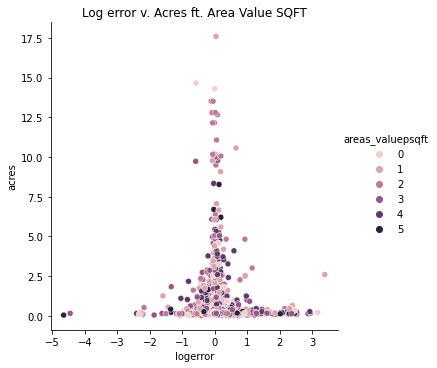

In [65]:
sns.relplot(data=train, 
            x="logerror",
            y="acres", 
            hue = "areas_valuepsqft").set(
                title="Log error v. Acres ft. Area Value SQFT")
plt.show()

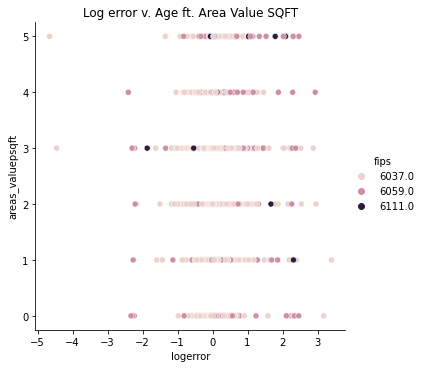

In [66]:
sns.relplot(data=train, 
            x="logerror",
            y="areas_valuepsqft", 
            hue = "fips").set(
                title="Log error v. Age ft. Area Value SQFT")
plt.show()

In [67]:
# ----

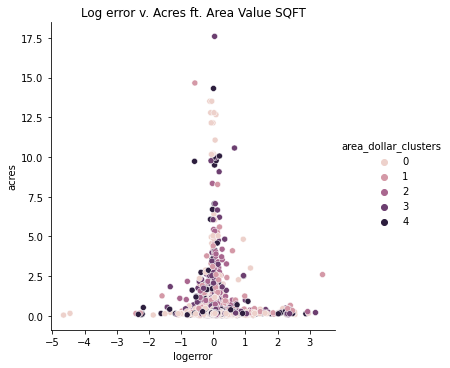

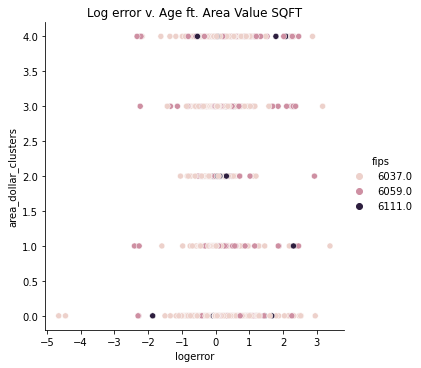

In [68]:
sns.relplot(data=train, 
            x="logerror",
            y="acres", 
            hue = "area_dollar_clusters").set(
                title="Log error v. Acres ft. Area Value SQFT")
sns.relplot(data=train, 
            x="logerror",
            y="area_dollar_clusters", 
            hue = "fips").set(
                title="Log error v. Age ft. Area Value SQFT")
plt.show()

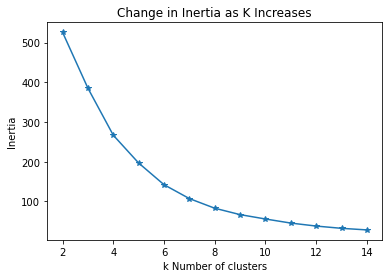

In [69]:
elbow(train_scaled, ['logerror'])

--------
#### Hypothesis Testing (including using Clusters):

In [70]:
# set Significance Level
alf = 0.05

In [71]:
# 1 Sample T-Testing
upper_bedroom_logerror = train.logerror[train.bedrooms > train.bedrooms.median()]
expected_logerror_mean = train.logerror.mean()

In [72]:
upper_bedroom_logerror, expected_logerror_mean

(21709   -0.113457
 8922    -0.042487
 2449     0.014773
 36663   -0.006518
 17273   -0.021674
            ...   
 21072   -0.061333
 23499    0.006548
 1016     0.057395
 40559    0.047239
 39377    0.027948
 Name: logerror, Length: 10746, dtype: float64,
 0.017657473610214174)

In [73]:
train.bedrooms.median()

3.0

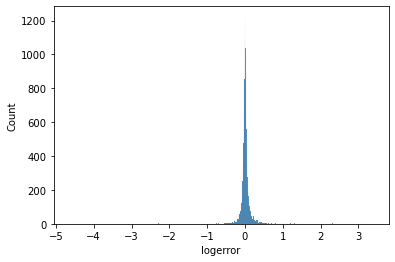

In [74]:
sns.histplot(data = train, x= 'logerror')
plt.show()

Log Error is 2-tailed:

- H0: Mean Log Error of Properties with > 3 bedrooms = Mean Log Error of all Properties
- Ha: Mean Log Error of Properties with > 3 bedrooms != Mean Log Error of all Properties

In [75]:
t, p = stats.ttest_1samp(upper_bedroom_logerror, expected_logerror_mean)
if p < alf:
    print("We can reject the Null Hypothosis. There is some significant difference.")
else:
    print("We cannot reject the Null Hypothosis, there is little to no significant difference.")

We can reject the Null Hypothosis. There is some significant difference.


- H0: Mean Log Error of Properties with <= 3 bedrooms = Mean Log Error of all Properties
- Ha: Mean Log Error of Properties with <= 3 bedrooms != Mean Log Error of all Properties

In [76]:
lower_bedroom_logerror = train.logerror[train.bedrooms <= train.bedrooms.median()]

In [77]:
# checking the flip side:
t, p = stats.ttest_1samp(lower_bedroom_logerror, expected_logerror_mean)
if p < alf:
    print("We can reject the Null Hypothosis. There is some significant difference.")
else:
    print("We cannot reject the Null Hypothosis, there is little to no significant difference.")

We can reject the Null Hypothosis. There is some significant difference.


> H0: No Variance between Houses with 3 or Less Bedrooms Log Error and Houses with more than 3 Bedrooms Log Error.

> Ha: Variance between Log error of houses with 3 or less bedrooms and houses with more than 3 Bedrooms.

In [78]:
# Levene for variance
stat, pval = stats.levene(lower_bedroom_logerror, upper_bedroom_logerror)
if p < alf:
    print("We can reject the null Hypothesis. There is a difference in Log Error between houses with 3 or less bedrooms, and those with more than 3 bedrooms.")
else:
    print("We cannot reject the null Hypothesis, there is no significant difference in log error by number of bedrooms")

We can reject the null Hypothesis. There is a difference in Log Error between houses with 3 or less bedrooms, and those with more than 3 bedrooms.


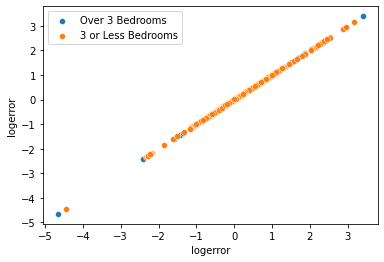

In [79]:
sns.scatterplot(df.logerror, upper_bedroom_logerror, label='Over 3 Bedrooms')
sns.scatterplot(df.logerror, lower_bedroom_logerror, label = '3 or Less Bedrooms')
plt.legend()
plt.show()

-----

#### Cluster Means vs Each Other
##### ANOVA test

In [80]:
train.columns

Index(['parcelid', 'logerror', 'bathrooms', 'bedrooms', 'area', 'fips',
       'lotsizesquarefeet', 'tax_value', 'tax_amount', 'LA', 'Orange',
       'Ventura', 'age', 'age_bin', 'tax_rate', 'acres', 'acres_bin',
       'sqft_bin', 'structure_dollar_per_sqft', 'structure_dollar_sqft_bin',
       'bath_bed_ratio', 'area_dollar_clusters', 'area_bedbath_clusters',
       'acre_bath_value', 'areas_valuepsqft'],
      dtype='object')

Structure Area Price Per Sqft (dollars) + Area Cluster
- step 1: Plot Distributions (ie. Histograms!)

In [81]:
train.area_dollar_clusters.unique()

array([3, 0, 1, 4, 2], dtype=int32)

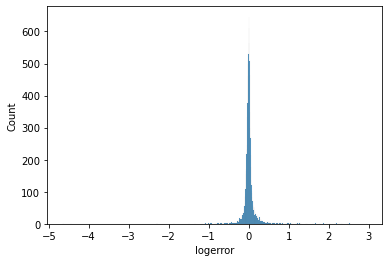

In [82]:
sns.histplot(x= train.logerror[train.area_dollar_clusters == 0])
plt.show()

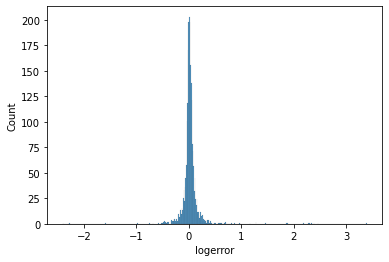

In [83]:
sns.histplot(x= train.logerror[train.area_dollar_clusters == 1])
plt.show()

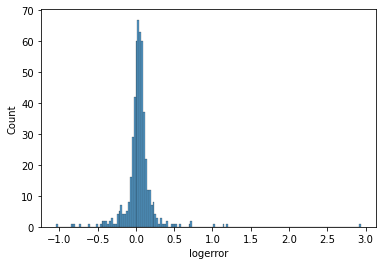

In [84]:
sns.histplot(x= train.logerror[train.area_dollar_clusters == 2])
plt.show()

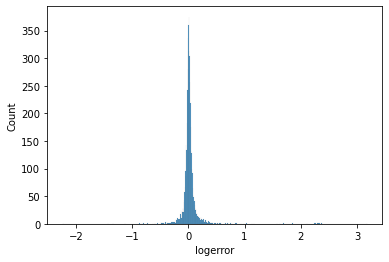

In [85]:
sns.histplot(x= train.logerror[train.area_dollar_clusters == 3])
plt.show()

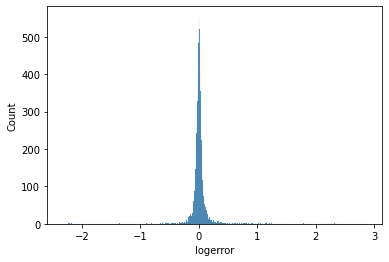

In [86]:
sns.histplot(x= train.logerror[train.area_dollar_clusters == 4])
plt.show()

In [87]:
# Equal Variance?
print(train.logerror[train.area_dollar_clusters == 0].var())
print(train.logerror[train.area_dollar_clusters == 1].var())
print(train.logerror[train.area_dollar_clusters == 2].var())
print(train.logerror[train.area_dollar_clusters == 3].var())
print(train.logerror[train.area_dollar_clusters == 4].var())

0.03158410941481195
0.048188449036118075
0.048692644880238445
0.028881715527841346
0.022948347124712706


In [88]:
Clu0 = train.logerror[train.area_dollar_clusters == 0]
Clu1 = train.logerror[train.area_dollar_clusters == 1]
Clu2 = train.logerror[train.area_dollar_clusters == 2]
Clu3 = train.logerror[train.area_dollar_clusters == 3]
Clu4 = train.logerror[train.area_dollar_clusters == 4]

In [89]:
stat, p = stats.bartlett(Clu0, Clu1, Clu2, Clu3, Clu4)

if p < alf:
    print("We fail to reject a Null hypothesis. There is not sufficient evidence to say the groups have different variances.")
else:
    print("We can reject the Null Hypothesis. The groups appear to have different variances")

We fail to reject a Null hypothesis. There is not sufficient evidence to say the groups have different variances.


Normal Distributions, 2 tailed, similar variances.
- Step 2: Hypotheses.

- H0: Mean of Log Error for Cluster A is Similar to Mean of Log error for Cluster B.
- Ha: Mean of Log Error for Cluster A is significantly different from Mean of Log Error for Cluster B.

In [90]:
t, p = stats.f_oneway(Clu0, Clu1, Clu2, Clu3, Clu4)
if p < alf:
    print("We can reject the Null Hypothosis. There is some significant difference in Log Error Means.")
else:
    print("We cannot reject the Null Hypothosis, there is little to no significant difference. in Log Error Means")

We can reject the Null Hypothosis. There is some significant difference in Log Error Means.


In [91]:
Clu0 = train.logerror[train.area_bedbath_clusters == 0]
Clu1 = train.logerror[train.area_bedbath_clusters == 1]
Clu2 = train.logerror[train.area_bedbath_clusters == 2]
Clu3 = train.logerror[train.area_bedbath_clusters == 3]
Clu4 = train.logerror[train.area_bedbath_clusters == 4]

In [92]:
stat, p = stats.bartlett(Clu0, Clu1, Clu2, Clu3, Clu4)

if p < alf:
    print("We fail to reject a Null hypothesis. There is not sufficient evidence to say the groups have different variances.")
else:
    print("We can reject the Null Hypothesis. The groups appear to have different variances")

We can reject the Null Hypothesis. The groups appear to have different variances


In [93]:
t, p = stats.f_oneway(Clu0, Clu1, Clu2, Clu3, Clu4)
if p < alf:
    print("We can reject the Null Hypothesis. There is some significant difference in Log Error Means.")
else:
    print("We cannot reject the Null Hypothesis, there is little to no significant difference. in Log Error Means")

We cannot reject the Null Hypothesis, there is little to no significant difference. in Log Error Means


In [94]:
Clu0 = train.logerror[train.acre_bath_value == 0]
Clu1 = train.logerror[train.acre_bath_value == 1]
Clu2 = train.logerror[train.acre_bath_value == 2]
Clu3 = train.logerror[train.acre_bath_value == 3]
Clu4 = train.logerror[train.acre_bath_value == 4]
Clu5 = train.logerror[train.acre_bath_value == 5]

In [95]:
stat, p = stats.bartlett(Clu0, Clu1, Clu2, Clu3, Clu4, Clu5)

if p < alf:
    print("We fail to reject a Null hypothesis. There is not sufficient evidence to say the groups have different variances.")
else:
    print("We can reject the Null Hypothesis. The groups appear to have different variances")

We fail to reject a Null hypothesis. There is not sufficient evidence to say the groups have different variances.


In [96]:
t, p = stats.f_oneway(Clu0, Clu1, Clu2, Clu3, Clu4, Clu5)
if p < alf:
    print("We can reject the Null Hypothosis. There is some significant difference in Log Error Means.")
else:
    print("We cannot reject the Null Hypothosis, there is little to no significant difference. in Log Error Means")

We can reject the Null Hypothosis. There is some significant difference in Log Error Means.


In [97]:
Clu0 = train.logerror[train.areas_valuepsqft == 0]
Clu1 = train.logerror[train.areas_valuepsqft == 1]
Clu2 = train.logerror[train.areas_valuepsqft == 2]
Clu3 = train.logerror[train.areas_valuepsqft == 3]
Clu4 = train.logerror[train.areas_valuepsqft == 4]
Clu5 = train.logerror[train.areas_valuepsqft == 5]

In [98]:
stat, p = stats.bartlett(Clu0, Clu1, Clu2, Clu3, Clu4, Clu5)

if p < alf:
    print("We fail to reject a Null hypothesis. There is not sufficient evidence to say the groups have different variances.")
else:
    print("We can reject the Null Hypothesis. The groups appear to have different variances")

We fail to reject a Null hypothesis. There is not sufficient evidence to say the groups have different variances.


In [99]:
t, p = stats.f_oneway(Clu0, Clu1, Clu2, Clu3, Clu4, Clu5)
if p < alf:
    print("We can reject the Null Hypothosis. There is some significant difference in Log Error Means.")
else:
    print("We cannot reject the Null Hypothosis, there is little to no significant difference. in Log Error Means")

We can reject the Null Hypothosis. There is some significant difference in Log Error Means.


## Modeling

In [100]:
#initializing model functions and preparing data splits for modeling.
OLS = lm.LinearRegression()
LassoLars = lm.LassoLars(normalize = True)
lm2 = LinearRegression(normalize=True)
pf = PolynomialFeatures(degree=2)

In [101]:
# Establishing model baseline.
baseline = baseline_mean(y_validate, "logerror")
baseline

0.01803331261307555

In [102]:
X_train_s['area_dollar_clusters'], X_train_s['area_bedbath_clusters'], X_train_s["acre_bath_value"], \
    X_train_s["areas_valuepsqft"] = \
    train['area_dollar_clusters'], train['area_bedbath_clusters'], train["acre_bath_value"], \
        train["areas_valuepsqft"]
        
X_train_s = cluster_dummies(X_train_s)

X_validate_s = cluster_dummies(X_validate_s)

X_test_s = cluster_dummies(X_test_s)

X_validate_s.head().T

,13751,41780,51314,46241,33339
parcelid,1.446278e+07,1.081089e+07,1.198425e+07,1.175164e+07,1.426746e+07
bathrooms,3.333333e-01,1.666667e-01,3.333333e-01,1.666667e-01,1.666667e-01
bedrooms,6.666667e-01,3.333333e-01,3.333333e-01,5.000000e-01,3.333333e-01
area,2.669142e-01,1.934818e-01,3.017739e-01,2.985767e-01,1.897690e-01
fips,6.059000e+03,6.037000e+03,6.037000e+03,6.037000e+03,6.059000e+03
lotsizesquarefeet,6.433000e+03,5.858000e+03,1.049000e+04,7.485000e+03,2.199000e+03
tax_value,6.038560e+05,4.023440e+05,1.707368e+06,1.190863e+06,3.423080e+05
tax_amount,9.263200e+03,4.934870e+03,2.081365e+04,1.447075e+04,4.087960e+03
LA,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
Orange,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


In [103]:
OLS.fit(X_train_s, y_train)
yhat_train = OLS.predict(X_train_s)
yhat = OLS.predict(X_validate_s)


rmse_train = mean_squared_error(y_train, yhat_train)**(0.5)
rmse_validate = mean_squared_error(y_validate, yhat)**(0.5)
print(round((rmse_train), 2))
print(round((rmse_validate), 2))
print(round((r2_score(y_validate, yhat)), 3))

0.17
0.17
-0.062


In [104]:
LassoLars.fit(X_train_s, y_train)
yhat_train = LassoLars.predict(X_train_s)
yhat = LassoLars.predict(X_validate_s)


rmse_train = mean_squared_error(y_train, yhat_train)**(0.5)
rmse_validate = mean_squared_error(y_validate, yhat)**(0.5)
print(round((rmse_train), 2))
print(round((rmse_validate), 2))
print(round((r2_score(y_validate, yhat)), 3))

0.17
0.17
-0.0


In [106]:
X_train_degree2 = pf.fit_transform(X_train_s)

X_validate_degree2 = pf.transform(X_validate_s)
X_test_degree2 = pf.transform(X_test_s)
validate_2 = pf.transform(X_validate_s)

lm2.fit(X_train_degree2, y_train)

yhat_train = lm2.predict(X_train_degree2)

rmse_train = mean_squared_error(y_train, yhat_train)**(0.5)
rmse_validate = mean_squared_error(y_validate, yhat)**(0.5)
print(round((rmse_train), 2))
print(round((rmse_validate), 2))
print(round((r2_score(y_validate, yhat)), 3))

0.17
0.17
-0.0


## Testing

In [107]:
OLS.fit(X_train_s, y_train)
yhat_train = OLS.predict(X_train_s)
yhat = OLS.predict(X_test_s)


rmse_train = mean_squared_error(y_train, yhat_train)**(0.5)
rmse_test = mean_squared_error(y_test, yhat)**(0.5)
print(round((rmse_train), 2))
print(round((rmse_test), 2))
print(round((r2_score(y_test, yhat)), 3))

(10136, 41)

(28378, 41)

0.17
0.21
-0.36
